<a href="https://colab.research.google.com/github/MarlenGabrich/GTF/blob/charact/Caract_pres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

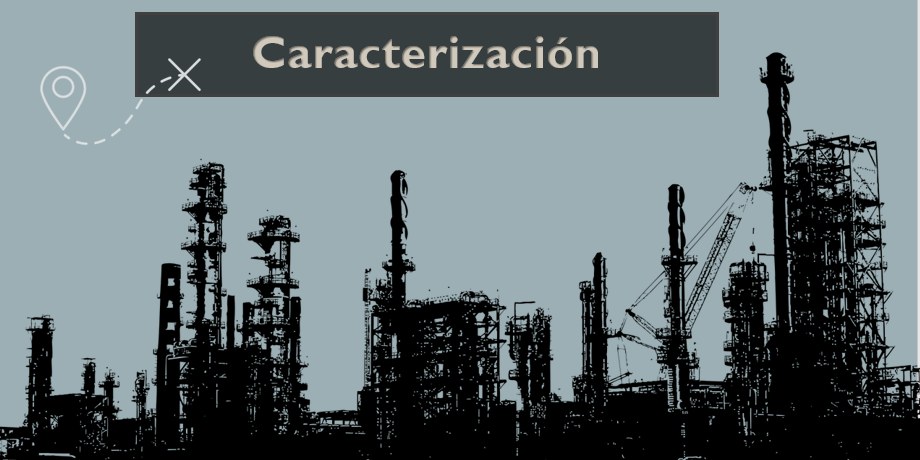


## Método que trata de definir un número conveniente de pseudocomponentes y sus parámetros en una Ecuación de Estado para representar fracciones pesadas de un dado fluido de reservorio.

---



**¿Qué herramientas voy a utilizar para aplicarlo?**

1.   Funciones de distribución
2.   Correlación de propiedades
3.   Lumping

In [1]:
# Módulos:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from math import log
import scipy

In [2]:
# Lectura de archivo
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/main/com-fede" > com.csv
df = pd.read_csv('com.csv')

#Acomodo el índice e imprimo
df = df.reset_index(drop=False).rename(columns={'index': 'ID'})
df = df.set_index("component")
df

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   667  100   667    0     0   3923      0 --:--:-- --:--:-- --:--:--  3923


,ID,molar_percentage,molar_mass,density
component,,,,
N2,0,0.49,—,—
CO2,1,0.31,—,—
C1,2,44.01,—,—
C2,3,3.84,—,—
C3,4,1.12,—,—
iC4,5,0.61,—,—
nC4,6,0.72,—,—
iC5,7,0.69,—,—
nC5,8,0.35,—,—


### Single Carbon Number 
Hago una primera agrupación de limpieza para trabajar con SCN.



In [3]:
# Saco la división i-C y n-C
letdel = "ni(\d+)"
for i in range (len(letdel)-5):
  df.index = df.index.str.replace(letdel[i],r"",regex=True)

#Agrupo y ordeno
df_ID = df.groupby([df.index])['ID'].agg('mean')
df_mbc = df.groupby(['component','molar_mass','density'])['molar_percentage'].agg('sum').reset_index().set_index('component').assign(ID=df_ID)
df_mbc = df_mbc.sort_values(by='ID', ascending=True)
df_mbc

,molar_mass,density,molar_percentage,ID
component,,,,
N2,—,—,0.49,0.0
CO2,—,—,0.31,1.0
C1,—,—,44.01,2.0
C2,—,—,3.84,3.0
C3,—,—,1.12,4.0
C4,—,—,1.33,5.5
C5,—,—,1.04,7.5
C6,—,—,1.04,9.0
C7,96,0.738,2.87,10.0


Text(17, 8, '100.02')

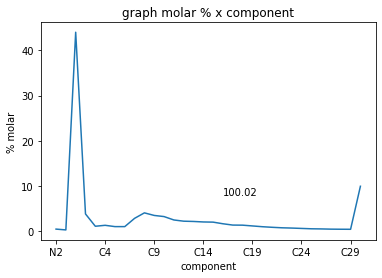

In [4]:
df_mbc['molar_percentage'][:].plot()
plt.ylabel('% molar')
plt.title('graph molar % x component')
suma = df_mbc['molar_percentage'].sum()
plt.text(17,8,round(suma,2))

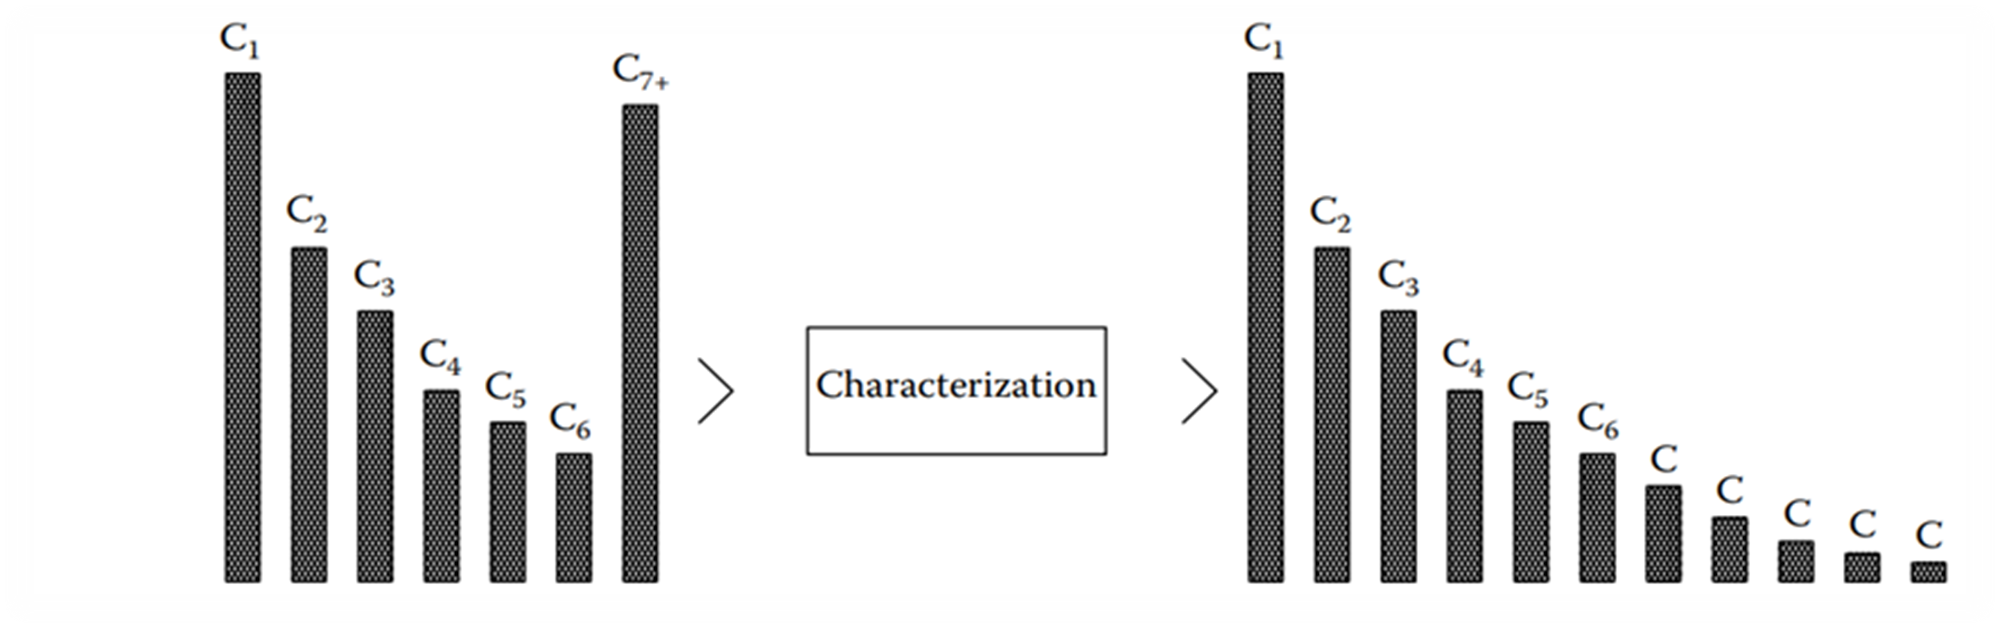

# 1. Función de distribución

Permiten extender la distribución representando la fracción residual como fracciones de SCN.


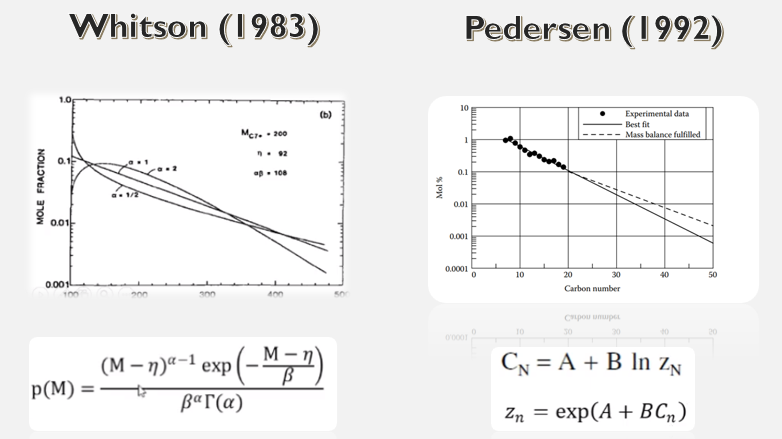


In [30]:
# defino:
z_plus_max = df_mbc["molar_percentage"].values[-1]
m_plus_max = float(df_mbc["molar_mass"].values[-1])
c_max = 80 #Pedersen
c_plus_n = int(df_mbc.index.values[-1].replace('C',"").replace('+',""))

#Voy a ajustar desde C8, entonces:
z_exp = df_mbc['molar_percentage']['C8':df_mbc.index[-2]].astype(float)
rho_exp = df_mbc['density']['C8':df_mbc.index[-2]].astype(float)

c_n=df_mbc.index
cdel = "C+"
for i in range (len(cdel)):
  c_n = c_n.str.replace(cdel[i],r"",regex=True)
c_n=c_n.values[9:-1].astype('int64')

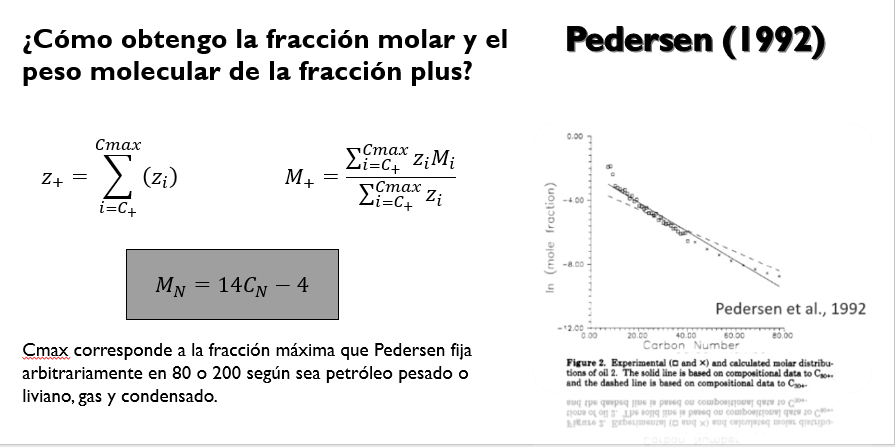

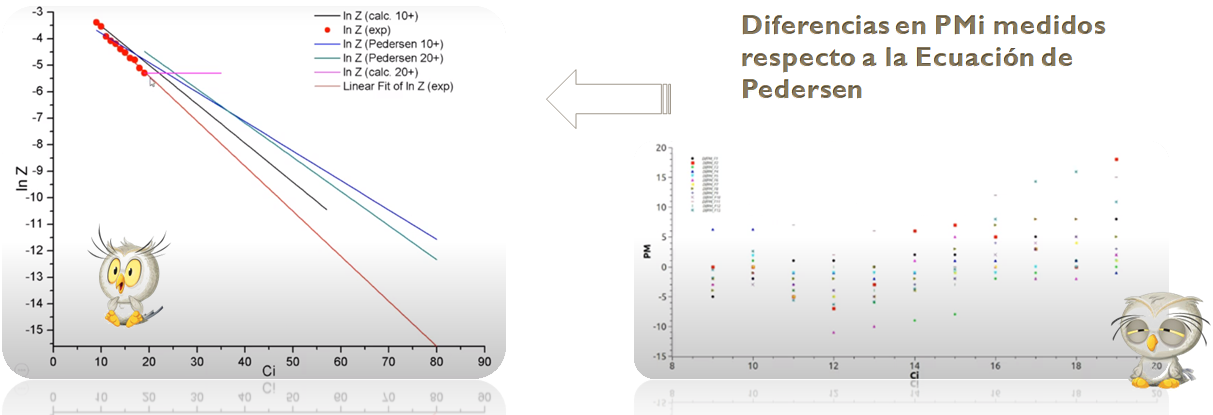

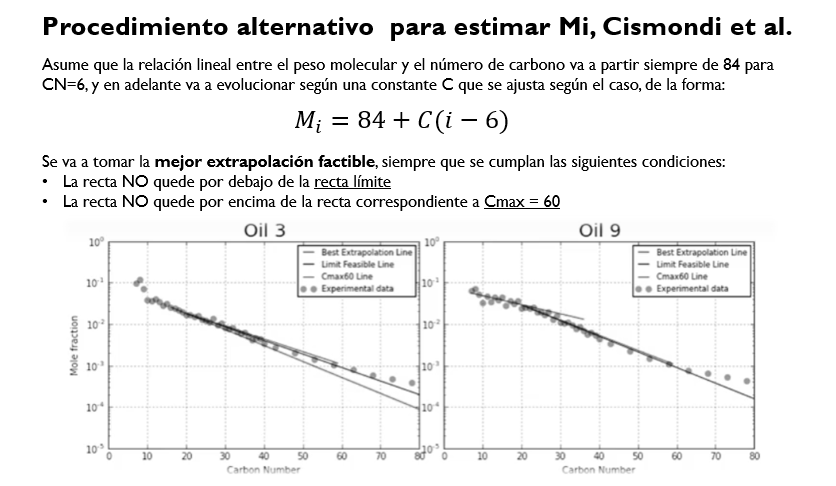

## Ajuste de parámetros

In [6]:
from scipy.optimize import curve_fit # Ajustar curva
from scipy.optimize import root_scalar # Hallar ceros
from scipy.optimize import minimize, minimize_scalar # Minimizar funciones

Ecuaciones utilizadas:

In [7]:
from matplotlib.colors import LogNorm
def carbon_number(z, A, B):
    return A + B * np.log(z)

def molar_fraction(cn, A, B):
    return np.exp((cn - A)/B)

def pedersen_M(cn):
    return 14 * cn - 4

def pedersen_rho(cn,L,M):
    return L + M*np.log(cn)

def cismondi_M(cn, C):
    return 84 + C*(cn - 6)

def cismondi_z(cn, Ac, Bc):
    return np.exp(Ac*cn + Bc)

def cismondi_rho(cn,AD):
    BD = 0.685 - AD*np.exp(-0.6)
    return AD*(np.exp(-cn/10)) + BD

In [8]:
A, B = curve_fit(carbon_number, z_exp, c_n)[0]
Ac, Bc= curve_fit(cismondi_z, c_n, z_exp)[0]
L, M = curve_fit(pedersen_rho, c_n, rho_exp)[0]
AD = curve_fit(cismondi_rho, c_n, rho_exp)[0]
 
exp_molar_mass = df_mbc["molar_mass"]['C8':df_mbc.index[-2]].astype(float)
C = curve_fit(cismondi_M, c_n, exp_molar_mass)[0].astype(float)
C

array([13.74068934])

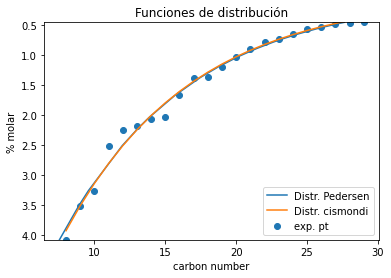

In [9]:
plt.plot(carbon_number(z_exp, A, B),z_exp, label = 'Distr. Pedersen')
plt.plot(c_n,cismondi_z(c_n,Ac,Bc),label= 'Distr. cismondi')
plt.scatter(c_n,z_exp, label = 'exp. pt')
plt.ylabel('% molar')
plt.xlabel('carbon number')
plt.ylim(max(z_exp),min(z_exp))
plt.title('Funciones de distribución')
plt.legend(loc='lower right')

#plt.xlim(0,12)
#plt.ylim(5, 1.5)

## Minimización de funciones

In [10]:
def res_fraction(c_max, c_min, m_func):                                                                         
    c_range = np.linspace(c_min, c_max, dtype=int)
    z_values = molar_fraction(c_range, A, B)                                      #calcula la fracción molar con la ec. de Pedersen
    m_values = m_func(c_range)                                                    #saca los valores de masa molar de todo el rango de nc con la ec. que elijo
    m_plus = np.array([])                                                         
    c = c_min-1

    for i in range(0, int(c_max)):
        c +=1

        m_plus = np.append(                                                       #completa Masa molar de la fracción + (ecuación de Pedersen) para dif. Cmax
            m_plus,
            (z_values[:i]*m_values[:i]).sum() / z_values[:i].sum()
        )    
        if m_plus[i]>=m_plus_max: 
          break

    return z_values, c_range,c, m_values, m_plus  

In [19]:
z, c_range,c ,m, mp = res_fraction(40,c_plus_n, pedersen_M)
mp[-1],c

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


(449.90348637890844, 63)

In [12]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/KatzFiroo"> KatzFiroo.csv
KF = pd.read_csv('KatzFiroo.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   500  100   500    0     0   3703      0 --:--:-- --:--:-- --:--:--  3703


In [13]:
Cn_max = c                                     
cn_mini = c_n[-1]

"""MplusPed = dfmin['molarmass_plus'][36]"""    #Valor muy diferente al de tabla exp.
"""zplus = dfmin['molarperc_values'][36]"""     #Valor muy diferente al de tabla exp

c_dist = np.array([range(c_n[-1]+1,Cn_max)])

mm_plus = float(df_mbc['molar_mass'][-1])
mp_plus = float(df_mbc['molar_percentage'][-1])

#Cismondi 
Mmi_c = cismondi_M(c_dist,C).round(2)                 #tendencia aum. OK
zi_c = cismondi_z(c_dist,Ac,Bc).round(2)
rho_cis = cismondi_rho(c_dist,AD).round(2)

#Pedersen
Mmi_ped = pedersen_M(c_dist).round(2)                    #aumenta OK
zi_ped = molar_fraction(c_dist,A,B).round(2)             #disminuye OK
rho_ped = pedersen_rho(c_dist,L,M).round(2)

In [28]:
df_ped = df_mbc.drop([df_mbc.index[-1]],axis=0).reset_index().drop('ID',axis=1)
df_cis = df_mbc.drop([df_mbc.index[-1]],axis=0).reset_index().drop('ID',axis=1)

for i in range(0,Cn_max-cn_mini-1):
  df_ped = df_ped.append({'component':'C'+str(cn_mini+1+i),'molar_mass':Mmi_ped[0:,i], 'molar_percentage':zi_ped[0:,i],'density':rho_ped[0:,i]},ignore_index=True)
  df_cis = df_cis.append({'component':'C'+str(cn_mini+1+i),'molar_mass':Mmi_c[0:,i],'molar_percentage':zi_c[0:,i],'density':rho_cis[0:,i]}, ignore_index=True)

# Molar mass Pedersen check con Katz y Firoozabadi(lb/lb-mol)
df_ped['molar_percentage'].sum(), df_cis['molar_percentage'].sum() 
df_ped.set_index('component'), df_cis.set_index('component') 

(          molar_mass density molar_percentage
 component                                    
 N2                 —       —             0.49
 CO2                —       —             0.31
 C1                 —       —            44.01
 C2                 —       —             3.84
 C3                 —       —             1.12
 ...              ...     ...              ...
 C58            [808]  [0.97]           [0.02]
 C59            [822]  [0.97]           [0.01]
 C60            [836]  [0.98]           [0.01]
 C61            [850]  [0.98]           [0.01]
 C62            [864]  [0.98]           [0.01]
 
 [64 rows x 3 columns],           molar_mass density molar_percentage
 component                                    
 N2                 —       —             0.49
 CO2                —       —             0.31
 C1                 —       —            44.01
 C2                 —       —             3.84
 C3                 —       —             1.12
 ...              ...     ...      

In [41]:
e_ped = (100 - df_ped['molar_percentage'].sum()[0])/(c-c_plus_n)
e_cis = (100 - df_cis['molar_percentage'].sum()[0])/(c-c_plus_n)
pp = c_plus_n-1

for i in df_ped['molar_percentage'][c_plus_n:]:
  pp +=1
  df_ped['molar_percentage'][pp] = df_ped['molar_percentage'][pp]+e_ped

pc = c_plus_n-1
for i in df_cis['molar_percentage'][c_plus_n:]:
  pc+=1
  df_cis['molar_percentage'][pc] = df_cis['molar_percentage'][pc]+e_cis

df_ped, df_cis
df_ped['molar_percentage'].sum().round(2)[0], df_cis['molar_percentage'].sum().round(2)[0]

(100.0, 100.0)

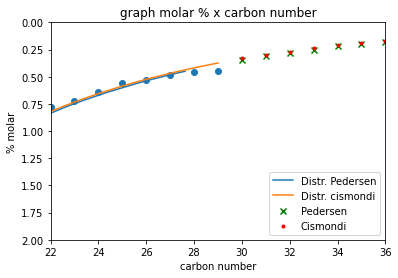

In [42]:
plt.plot(carbon_number(z_exp, A, B),z_exp, label = 'Distr. Pedersen')
plt.plot(c_n,cismondi_z(c_n,Ac,Bc),label= 'Distr. cismondi')
plt.scatter(c_n,z_exp)
plt.ylabel('% molar')
plt.xlabel('carbon number')
plt.ylim(2,0)
plt.xlim(22,36)
plt.title('graph molar % x carbon number')


#Pedersen
plt.scatter(c_dist,zi_ped,label = 'Pedersen', marker = 'x', color='green')
#Cismondi
plt.scatter(c_dist,zi_c, label = 'Cismondi', marker = '.', color='red')

plt.legend(loc='lower right')

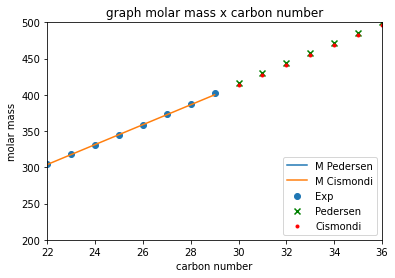

In [43]:
plt.plot(c_n, carbon_number(z_exp, A, B), label = 'M Pedersen')
plt.plot(c_n,cismondi_M(c_n,C),label= 'M Cismondi')
plt.scatter(c_n,exp_molar_mass, label='Exp')
plt.ylabel('molar mass')
plt.xlabel('carbon number')
plt.ylim(200,500)
plt.xlim(22,36)
plt.title('graph molar mass x carbon number')

#Pedersen
plt.scatter(c_dist,Mmi_ped,label = 'Pedersen', marker = 'x', color='green')
#Cismondi
plt.scatter(c_dist,Mmi_c, label = 'Cismondi', marker = '.', color='red')

plt.legend(loc='lower right')

# 2. Pseudo-compuestos: Correlaciones de propiedades
## ***Pedersen*** :

# ✒ ${T_c}$ = ${c_1}$ ${\rho_1}$  + ${c_2}$ ln M + ${c_3}$ M + ${\frac{c4}{M}}$

# ✒ ln ${P_c}$ = ${d_1}$ + ${d_2}$ $\rho^{{d_5}}$ + ${\frac{d_3}{M}}$ + ${\frac{d_4}{M^{2}}}$

# ✒ ${m}$ = ${e_1}$ + ${e_2}$ M  + ${e_3}$ ${\rho}$ + ${e_4}$ ${M^{2}}$


m se relaciona con ${\omega}$, según corresponda:

### SRK:
## m = 0.480 + 1.574 ${\omega}$ - 0.176 ${{\omega}^{2}}$

### PR:
## m = 0.37464 + 1.54226 ${\omega}$ - 0.26992 ${{\omega}^{2}}$





In [44]:
def pedersen_Tc(M,rho,c1,c2,c3,c4):
    return c1*rho + c2*(np.log(M)) + c3*M + (c4/M)

def pedersen_Pc(M,rho,d1,d2,d3,d4,d5):
    lnPc = d1 + d2*(rho*np.exp(d5) + d3/M + d4/(M*np.exp(2)))
    return np.exp(lnPc)

In [45]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-C"> CoefC.csv
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-d"> Coefd.csv
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/Coeff-e"> Coefe.csv

Coef_c = pd.read_csv('CoefC.csv')
Coef_d = pd.read_csv('Coefd.csv')
Coef_e = pd.read_csv('Coefe.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    595      0 --:--:-- --:--:-- --:--:--   595
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   112  100   112    0     0    751      0 --:--:-- --:--:-- --:--:--   751
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   113  100   113    0     0    882      0 --:--:-- --:--:-- --:--:--   882


In [47]:
df_ped['Tc_SRK'] = np.nan
df_ped['Pc_SRK'] = np.nan
df_ped['Tc_PR'] = np.nan
df_ped['Pc_PR'] = np.nan

df_cis['Tc_SRK'] = np.nan
df_cis['Pc_SRK'] = np.nan
df_cis['Tc_PR'] = np.nan
df_cis['Pc_PR'] = np.nan

In [48]:
lst = [i for i in range(8,Cn_max+1)]
for i in lst:
  M_cismondi = float(df_cis['molar_mass'][i])
  rho_cismondi = float(df_cis['density'][i])
  M_pedersen = float(df_ped['molar_mass'][i])
  rho_pedersen = float(df_ped['density'][i])

  Tc_PEDER_SRK = pedersen_Tc(M_pedersen,rho_pedersen,Coef_c['SRK'][0],Coef_c['SRK'][1],Coef_c['SRK'][2],Coef_c['SRK'][3])
  Pc_PEDER_SRK = pedersen_Pc(M_pedersen,rho_pedersen,Coef_d['SRK'][0], Coef_d['SRK'][1],Coef_d['SRK'][2], Coef_d['SRK'][3],Coef_d['SRK'][4])
  Tc_PEDER_PR = pedersen_Tc(M_pedersen,rho_pedersen,Coef_c['PR'][0],Coef_c['PR'][1],Coef_c['PR'][2],Coef_c['PR'][3])
  Pc_PEDER_PR = pedersen_Pc(M_pedersen,rho_pedersen,Coef_d['PR'][0], Coef_d['PR'][1], Coef_d['PR'][2], Coef_d['PR'][3],Coef_d['PR'][4])

  Tc_CISM_SRK = pedersen_Tc(M_cismondi,rho_cismondi,Coef_c['SRK'][0],Coef_c['SRK'][1],Coef_c['SRK'][2],Coef_c['SRK'][3])
  Pc_CISM_SRK = pedersen_Pc(M_cismondi,rho_cismondi,Coef_d['SRK'][0], Coef_d['SRK'][1], Coef_d['SRK'][2], Coef_d['SRK'][3],Coef_d['SRK'][4])
  Tc_CISM_PR = pedersen_Tc(M_cismondi,rho_cismondi,Coef_c['PR'][0],Coef_c['PR'][1],Coef_c['PR'][2],Coef_c['PR'][3])
  Pc_CISM_PR = pedersen_Pc(M_cismondi,rho_cismondi,Coef_d['PR'][0], Coef_d['PR'][1], Coef_d['PR'][2], Coef_d['PR'][3],Coef_d['PR'][4])

  df_ped['Tc_SRK'][i] = Tc_PEDER_SRK
  df_ped['Pc_SRK'][i] = Pc_PEDER_SRK
  df_ped['Tc_PR'][i] = Tc_PEDER_PR
  df_ped['Pc_PR'][i] = Pc_PEDER_PR

  df_cis['Tc_SRK'][i] = Tc_CISM_SRK
  df_cis['Pc_SRK'][i] = Pc_CISM_SRK
  df_cis['Tc_PR'][i] = Tc_CISM_PR
  df_cis['Pc_PR'][i] = Pc_CISM_PR

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to b

In [49]:
df_ped

,component,molar_mass,density,molar_percentage,Tc_SRK,Pc_SRK,Tc_PR,Pc_PR
0,N2,—,—,0.49,NaN,NaN,NaN,NaN
1,CO2,—,—,0.31,NaN,NaN,NaN,NaN
2,C1,—,—,44.01,NaN,NaN,NaN,NaN
3,C2,—,—,3.84,NaN,NaN,NaN,NaN
4,C3,—,—,1.12,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
59,C58,[808],[0.97],[0.2176470588233897],1082.453339,229.841594,1220.327665,5.813593
60,C59,[822],[0.97],[0.2076470588233897],1090.043643,233.890749,1230.705834,5.917279
61,C60,[836],[0.98],[0.2076470588233897],1099.238856,254.612218,1241.788349,6.190764
62,C61,[850],[0.98],[0.2076470588233897],1106.777472,258.802319,1252.108134,6.293904


In [50]:
df_cis

,component,molar_mass,density,molar_percentage,Tc_SRK,Pc_SRK,Tc_PR,Pc_PR
0,N2,—,—,0.49,NaN,NaN,NaN,NaN
1,CO2,—,—,0.31,NaN,NaN,NaN,NaN
2,C1,—,—,44.01,NaN,NaN,NaN,NaN
3,C2,—,—,3.84,NaN,NaN,NaN,NaN
4,C3,—,—,1.12,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
59,C58,[798.52],[0.93],[0.21176471103790975],1070.773415,172.981108,1210.346590,5.131986
60,C59,[812.26],[0.93],[0.21176471103790975],1078.240999,176.043879,1220.552628,5.223976
61,C60,[826.0],[0.93],[0.21176471103790975],1085.682632,179.056297,1230.729354,5.314474
62,C61,[839.74],[0.93],[0.21176471103790975],1093.099193,182.019171,1240.877759,5.403501


#Lumping
##Crit: "Average" Boiling Point (°C)

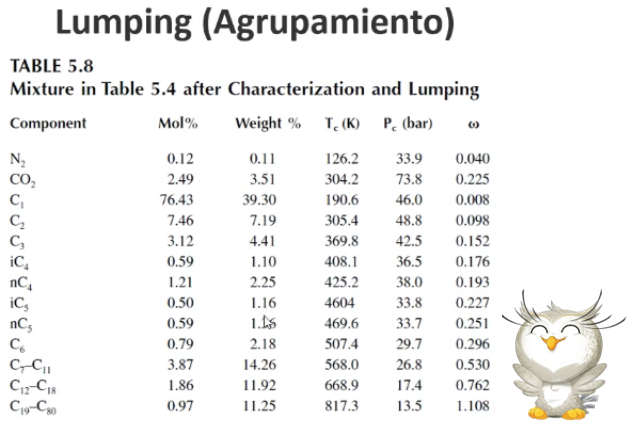

In [51]:
!curl "https://raw.githubusercontent.com/MarlenGabrich/GTF/charact/BoilingPoint"> BoilingPoint.csv
BP = pd.read_csv('BoilingPoint.csv')
BP

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   268  100   268    0     0   2077      0 --:--:-- --:--:-- --:--:--  2077


,CN,average_bp
0,C7,63.9
1,C8,91.9
2,C9,116.7
3,C10,142.2
4,C11,165.8
5,C12,187.2
6,C13,208.3
7,C14,227.2
8,C15,246.4
9,C16,266.0


In [52]:
df_cis['Boiling point'] = np.nan
df_ped['Boiling point'] = np.nan

for i in BP['CN']:
  posC1 = df_cis.index[df_cis['component']==i][0]
  posi= BP.index[BP['CN']==i][0]
  df_cis['Boiling point'][posC1]=BP[' average_bp'][posi]
  df_ped['Boiling point'][posC1]=BP[' average_bp'][posi]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


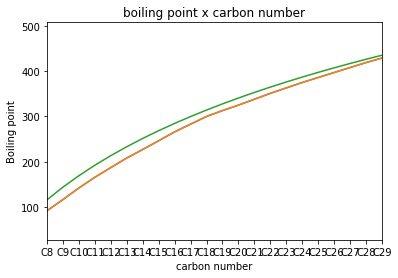

In [53]:
plt.plot(df_ped['component'], df_ped['Boiling point'], label = 'M Pedersen')
plt.plot(df_cis['component'],df_cis['Boiling point'],label= 'M Cismondi')
plt.ylabel('Boiling point')
plt.xlabel('carbon number')
plt.xlim(9,30)
plt.title('boiling point x carbon number')

x = BP['CN'].str.replace("C",r"",regex=True).values[:].astype('int64')
y = BP[' average_bp']

coefi = np.polyfit(np.log(x),y,1)
ym1 = np.array([])  

for i in range (len(x)):
  ym1 = np.append(ym1, coefi[0]*np.log(x[i])+ coefi[1])

plt.plot(x,ym1, label = 'ajuste BP')

In [54]:
def ajusteBP(x):
  return coefi[0]*np.log(x)+ coefi[1]

In [67]:
ic = int(df_cis['component'][37].replace('C',""))-1
for i in df_cis['component'][37:]:
  ic +=1
  pos = df_cis.index[df_cis['component']==i][0]
  df_cis['Boiling point'][pos]= ajusteBP(ic)
  df_ped['Boiling point'][pos]= ajusteBP(ic)
  
df_ped

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,component,molar_mass,density,molar_percentage,Tc_SRK,Pc_SRK,Tc_PR,Pc_PR,Boiling point
0,N2,—,—,0.49,NaN,NaN,NaN,NaN,NaN
1,CO2,—,—,0.31,NaN,NaN,NaN,NaN,NaN
2,C1,—,—,44.01,NaN,NaN,NaN,NaN,NaN
3,C2,—,—,3.84,NaN,NaN,NaN,NaN,NaN
4,C3,—,—,1.12,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
59,C58,[808],[0.97],[0.2176470588233897],1082.453339,229.841594,1220.327665,5.813593,610.006232
60,C59,[822],[0.97],[0.2076470588233897],1090.043643,233.890749,1230.705834,5.917279,614.537451
61,C60,[836],[0.98],[0.2076470588233897],1099.238856,254.612218,1241.788349,6.190764,618.992512
62,C61,[850],[0.98],[0.2076470588233897],1106.777472,258.802319,1252.108134,6.293904,623.373931


In [ ]:
for i in df_ped['Boiling point'][9:]:
  if (i
df_ped = df.groupby(['component','molar_mass','density'])['molar_percentage'].agg('sum').reset_index().set_index('component').assign(ID=df_ID)